In [ ]:
!pip install surprise

In [ ]:
!pip install pmdarima

In [ ]:
!pip install geopandas

In [3]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [121]:
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import plotly.graph_objects as go
import plotly.express as px

#**3. Financial Analysis**

### **Loading the Dataset**

This dataset includes financial statistics from 2013 to 2017 for a college football team. For the team, each row corresponds to a different year. The columns include the year, FBS league, NCAA division, city, IPEDS ID (the university's identification number), and other financial data, including total expenses, excess transfers back, medical costs, recruitment costs, athletic student aid, total revenues, and more.


The financial data is segmented into sections such match costs and travel, facilities and equipment, coaches' salaries, and support and admin salaries. Additionally, details on revenue streams including corporate sponsorships, advertising, licensing, and donations are provided. There is also data on academic spending across the entire university, athletics-related debt, annual debt service, leases, and rental costs.

In [136]:
# read in the xlsx file
revenue_df = pd.read_excel('NCAA Profit and Losses.xlsx')

# learn about the structure and substance of the dataset
revenue_df.head()

,IPEDS ID,School,Year,NCAA Subdivision,FBS Conference,City,State,Country,Total Expenses,Excess Transfers Back,...,"NCAA/Conference Distributions, Media Rights, and Post-Season Football",Ticket Sales,Institutional/Government Support,Student Fees,Total Academic Spending (University-Wide),Total Football Spending,Total Football Coaching Salaries,Athletics Related Debt,"Annual Debt Service, Leases and Rental Fees on Athletic Facilities",Profit
0,0,Unidentified,2005,Conference Median,Southeastern Conference,Birmingham,Alabama,United States,6.447470e+07,0.0,...,1.584381e+07,1.947051e+07,3.441110e+05,1.207275e+06,6.428373e+08,1.533035e+07,3.968172e+06,6.477897e+07,5.288934e+06,6.062091e+06
1,0,Unidentified,2005,Conference Median,Pacific-12 Conference,San Francisco,California,United States,4.969208e+07,0.0,...,1.056943e+07,1.177885e+07,4.596314e+06,1.381492e+06,1.095894e+09,1.250556e+07,2.986549e+06,1.106071e+07,1.228968e+06,2.720738e+05
2,0,Unidentified,2005,Conference Median,Mountain West Conference,Colorado Springs,Colorado,United States,2.619132e+07,0.0,...,4.439456e+06,3.665623e+06,8.980656e+06,2.475994e+06,5.458492e+08,6.657578e+06,1.998036e+06,1.248945e+06,2.915689e+05,4.017471e+06
3,0,Unidentified,2005,Conference Median,Big Ten Conference,Rosemont,Illinois,United States,6.963547e+07,0.0,...,1.585474e+07,2.323861e+07,1.624780e+06,0.000000e+00,1.639212e+09,1.478387e+07,3.622974e+06,4.883918e+07,4.915871e+06,5.615302e+06
4,0,Unidentified,2005,Conference Median,Independent,Independent,Independent,Independent,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [137]:
# check the basic information about the dataset
revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586 entries, 0 to 1585
Data columns (total 34 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   IPEDS ID                                                               1586 non-null   int64  
 1   School                                                                 1586 non-null   object 
 2   Year                                                                   1586 non-null   int64  
 3   NCAA Subdivision                                                       1586 non-null   object 
 4   FBS Conference                                                         1586 non-null   object 
 5   City                                                                   1586 non-null   object 
 6   State                                                                  1586 non-null   o

# **3.1. Expense analysis :**

We can examine the athletic department's costs and pinpoint the main cost factors. We can categorize the costs and compare them to past expenditure patterns or industry norms. This study might point out places where money is being wasted or where money might be saved.

3.1.1. Establish a list of expense categories before figuring out the overall costs and percentages for each. Then make a pie chart to show the breakdown of costs. Print the category-by-category expense breakdown in both dollars and percentages.

This information on athletic department costs can be used for analysis or presentation. The printed breakdown and pie chart give an understandable visual and numerical breakdown of the various spending categories. By doing so, it will be easier to spot areas where the department is spending more or less money and make better resource allocation choices.

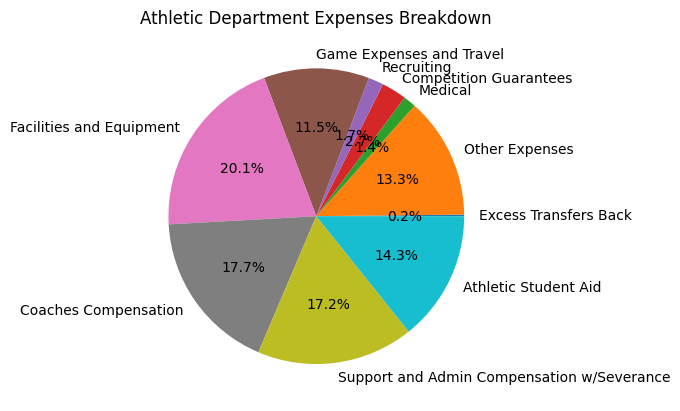

Expense breakdown by category:
Excess Transfers Back: $147,690,165 (0.2%)
Other Expenses: $11,303,522,186 (13.3%)
Medical: $1,175,767,597 (1.4%)
Competition Guarantees: $2,334,556,071 (2.7%)
Recruiting: $1,419,685,873 (1.7%)
Game Expenses and Travel: $9,840,416,777 (11.5%)
Facilities and Equipment: $17,164,489,409 (20.1%)
Coaches Compensation: $15,106,947,408 (17.7%)
Support and Admin Compensation w/Severance: $14,626,376,611 (17.2%)
Athletic Student Aid: $12,151,845,957 (14.3%)


In [84]:
# define expense categories
categories = ['Excess Transfers Back', 'Other Expenses', 'Medical',
              'Competition Guarantees', 'Recruiting', 'Game Expenses and Travel',
              'Facilities and Equipment', 'Coaches Compensation',
              'Support and Admin Compensation w/Severance', 'Athletic Student Aid']

# calculate total expenses and percentages by category
totals = revenue_df[categories].sum()
percentages = totals / totals.sum()

# plot expense breakdown
plt.pie(percentages, labels=categories, autopct='%1.1f%%')
plt.title('Athletic Department Expenses Breakdown')
plt.show()

# print expense breakdown by category
print('Expense breakdown by category:')
for category in categories:
    print(f'{category}: ${totals[category]:,.0f} ({percentages[category]*100:.1f}%)')

3.1.2. Athletic directors, NCAA officials, and other stakeholders could find this analysis to be quite insightful. Each NCAA division and FBS conference's overall spending are shown graphically by the heatmap. Administrators and sports directors might find areas where they might be able to cut costs or better manage resources by comparing the total costs throughout the subdivisions and conferences. This approach can also be used to examine individual sporting programs' financial success and spot trends over time.

The application of data analysis methods to uncover information on the financial health of NCAA athletic programs. Administrators and stakeholders can manage sports programs effectively by allocating resources and taking into account the trends and factors that influence costs.

<Axes: xlabel='FBS Conference', ylabel='NCAA Subdivision'>

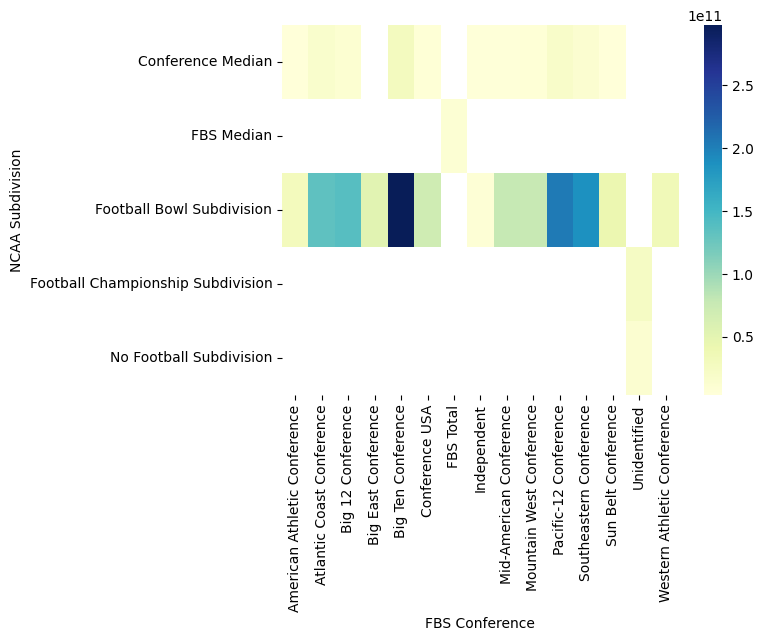

In [89]:
# group the data by NCAA Subdivision and FBS Conference
grouped_data = revenue_df.groupby(['NCAA Subdivision', 'FBS Conference'])['Total Expenses'].sum().reset_index()

# create a pivot table with NCAA Subdivision as rows, FBS Conference as columns, and Total Expenses as values
pivot_table = grouped_data.pivot(index='NCAA Subdivision', columns='FBS Conference', values='Total Expenses')

# plot a heatmap of the pivot table
sns.heatmap(pivot_table, cmap='YlGnBu')

# **3.2. Revenue analysis:**

The main sources of funding for the athletic department can be determined by analyzing the money it generates. We can segment the revenue into categories and assess the performance against standard metrics for the sector or previous patterns. This research can be used to pinpoint possible revenue sources or growth regions.

3.2.1. An athletic department's revenue breakdown by category is shown in a pie chart. Having a clear grasp of where the revenue is coming from and how much each category adds to the overall revenue is one advantage of doing this. This can be helpful in identifying areas of strength or weakness in the department's revenue streams and in decision-making processes such as where to spend resources and funds.

Overall, any business, including an athletic department, would benefit from having a solid understanding of the revenue breakdown by category as it can aid in financial planning, budgeting, and resource allocation.

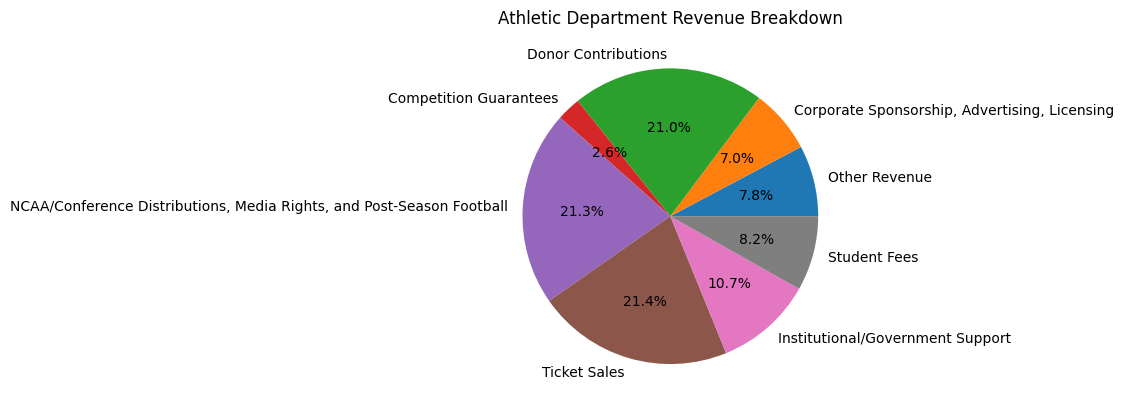

Revenue breakdown by category:
Other Revenue: $6,923,788,222 (7.8%)
Corporate Sponsorship, Advertising, Licensing: $6,250,312,421 (7.0%)
Donor Contributions: $18,750,402,431 (21.0%)
Competition Guarantees: $2,334,556,071 (2.6%)
NCAA/Conference Distributions, Media Rights, and Post-Season Football: $19,029,319,103 (21.3%)
Ticket Sales: $19,138,339,800 (21.4%)
Institutional/Government Support: $9,509,491,300 (10.7%)
Student Fees: $7,302,973,698 (8.2%)


In [20]:
# define revenue categories
categories = ['Other Revenue', 'Corporate Sponsorship, Advertising, Licensing', 
              'Donor Contributions', 'Competition Guarantees', 
              'NCAA/Conference Distributions, Media Rights, and Post-Season Football', 
              'Ticket Sales', 'Institutional/Government Support', 'Student Fees']

# calculate total revenues and percentages by category
totals = revenue_df[categories].sum()
percentages = totals / totals.sum()

# plot revenue breakdown
plt.pie(percentages, labels=categories, autopct='%1.1f%%')
plt.title('Athletic Department Revenue Breakdown')
plt.show()

# print revenue breakdown by category
print('Revenue breakdown by category:')
for category in categories:
    print(f'{category}: ${totals[category]:,.0f} ({percentages[category]*100:.1f}%)')

3.2.2. To see the percentage of overall revenue earned by each revenue category, a scatter plot is made. The scatter plot makes it simple to see which revenue streams are most responsible for the athletic department's overall revenue.

The sports department can decide which revenue categories to concentrate on and potentially enhance their revenue streams by carefully examining the revenue breakdown. For instance, the sports department may decide to pursue tactics to enhance ticket sales revenue, such as providing promotions, lowering ticket prices, or enhancing the fan experience, if ticket sales are not making up a sizable portion of the total revenue. To improve the financial health of the clubs, the athletic department can make data-driven decisions by looking at the revenue breakdown.

<ipython-input-24-0f1c9ea3aea3>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=90) # rotate x-axis tick labels by 90 degrees


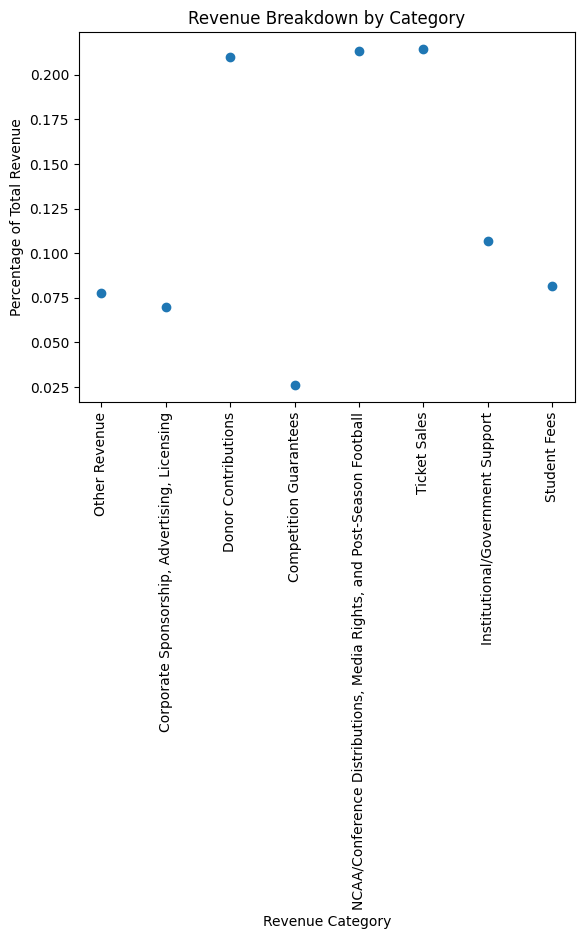

In [24]:
# define revenue categories
categories = ['Other Revenue', 'Corporate Sponsorship, Advertising, Licensing', 
              'Donor Contributions', 'Competition Guarantees', 
              'NCAA/Conference Distributions, Media Rights, and Post-Season Football', 
              'Ticket Sales', 'Institutional/Government Support', 'Student Fees']

# calculate total revenues and percentages by category
totals = revenue_df[categories].sum()
percentages = totals / totals.sum()

# create a scatter plot
fig, ax = plt.subplots()
ax.scatter(categories, percentages)
ax.set_xlabel('Revenue Category')
ax.set_ylabel('Percentage of Total Revenue')
ax.set_title('Revenue Breakdown by Category')
ax.set_xticklabels(categories, rotation=90) # rotate x-axis tick labels by 90 degrees

plt.show()

# **3.3. Profitability analysis:**

We can examine the athletic department's net income and contrast it with standard operating procedures or previous patterns. This examination can help determine the department's financial stability and capacity to continue operating over time.

3.3.1. Analyze the profitability of a dataset that includes financial data for NCAA athletic departments. Create categories for revenue and outlays. The total revenue, cost, and profit are then determined for each FBS Conference in the dataset.

The first graphic displays the overall schools' profit and loss over time. The second plot displays each school's profitability, arranged from highest to lowest profit.

Finally, use the KMeans technique to cluster the dataset according to revenue and spending categories. Then, make a scatter plot with points colored according to cluster membership, showing total earnings vs. total expenses for each institution.

In general, this research shows which clubs are the most lucrative as well as how different revenue and spending categories affect profitability. 

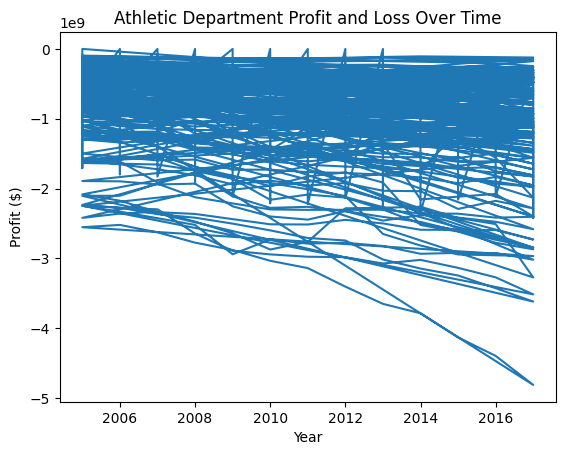

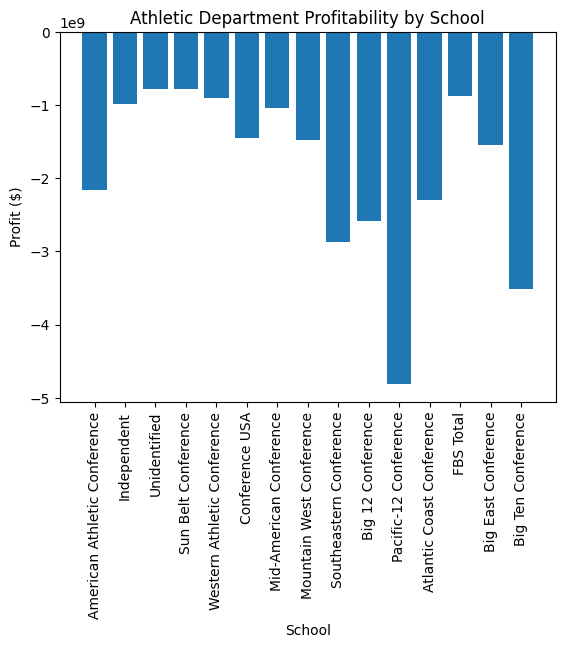

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


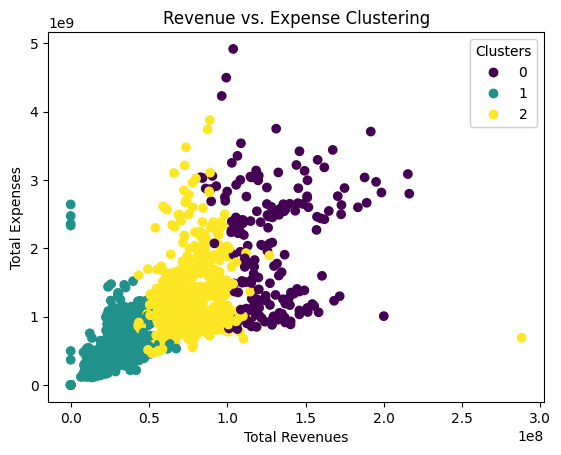

In [94]:
# define revenue and expense categories
revenue_categories = ['Other Revenue', 'Corporate Sponsorship, Advertising, Licensing', 
                      'Donor Contributions', 'Competition Guarantees', 
                      'NCAA/Conference Distributions, Media Rights, and Post-Season Football', 
                      'Ticket Sales', 'Institutional/Government Support', 'Student Fees']
expense_categories = ['Excess Transfers Back', 'Other Expenses', 'Medical', 'Competition Guarantees', 
                      'Recruiting', 'Game Expenses and Travel', 'Facilities and Equipment', 'Coaches Compensation', 
                      'Support and Admin Compensation w/Severance', 'Athletic Student Aid', 'Total Academic Spending (University-Wide)', 
                      'Total Football Spending', 'Total Football Coaching Salaries', 'Athletics Related Debt', 
                      'Annual Debt Service, Leases and Rental Fees on Athletic Facilities']

# calculate total revenues, expenses, and profits
revenue_df['Total Revenues'] = revenue_df[revenue_categories].sum(axis=1)
revenue_df['Total Expenses'] = revenue_df[expense_categories].sum(axis=1)
revenue_df['Profit'] = revenue_df['Total Revenues'] - revenue_df['Total Expenses']

# plot profit and loss over time
plt.plot(revenue_df['Year'], revenue_df['Profit'])
plt.xlabel('Year')
plt.ylabel('Profit ($)')
plt.title('Athletic Department Profit and Loss Over Time')
plt.show()

# plot profitability by school
df_sorted = revenue_df.sort_values(by='Profit', ascending=False)
plt.bar(df_sorted['FBS Conference'], df_sorted['Profit'])
plt.xticks(rotation=90)
plt.xlabel('School')
plt.ylabel('Profit ($)')
plt.title('Athletic Department Profitability by School')
plt.show()

# cluster schools based on revenue and expense categories
X = revenue_df[revenue_categories + expense_categories]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled)
revenue_df['Cluster'] = kmeans.labels_
fig, ax = plt.subplots()
scatter = ax.scatter(revenue_df['Total Revenues'], revenue_df['Total Expenses'], c=revenue_df['Cluster'])
plt.xlabel('Total Revenues')
plt.ylabel('Total Expenses')
plt.title('Revenue vs. Expense Clustering')
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend)
plt.show()

# **3.4. Benchmarking analysis:**

The athletic department's financial performance might be compared to that of other divisions or conferences. In order to make strategic decisions, this study can assist identify areas of strength or weakness in comparison to peers.

3.4.1. To determine areas where our clubs' athletic department may need to concentrate its efforts to strengthen its competitive position within the conference, we compare revenue and spending categories against other clubs in the conference. Our club can use this data to determine whether we need to boost revenue in specific categories, cut costs in specific areas, or do both to improve our position in the conference. This research can also show how our club's athletic department is doing in comparison to other universities in the conference, which can help the department make strategic decisions and determine its top priorities.

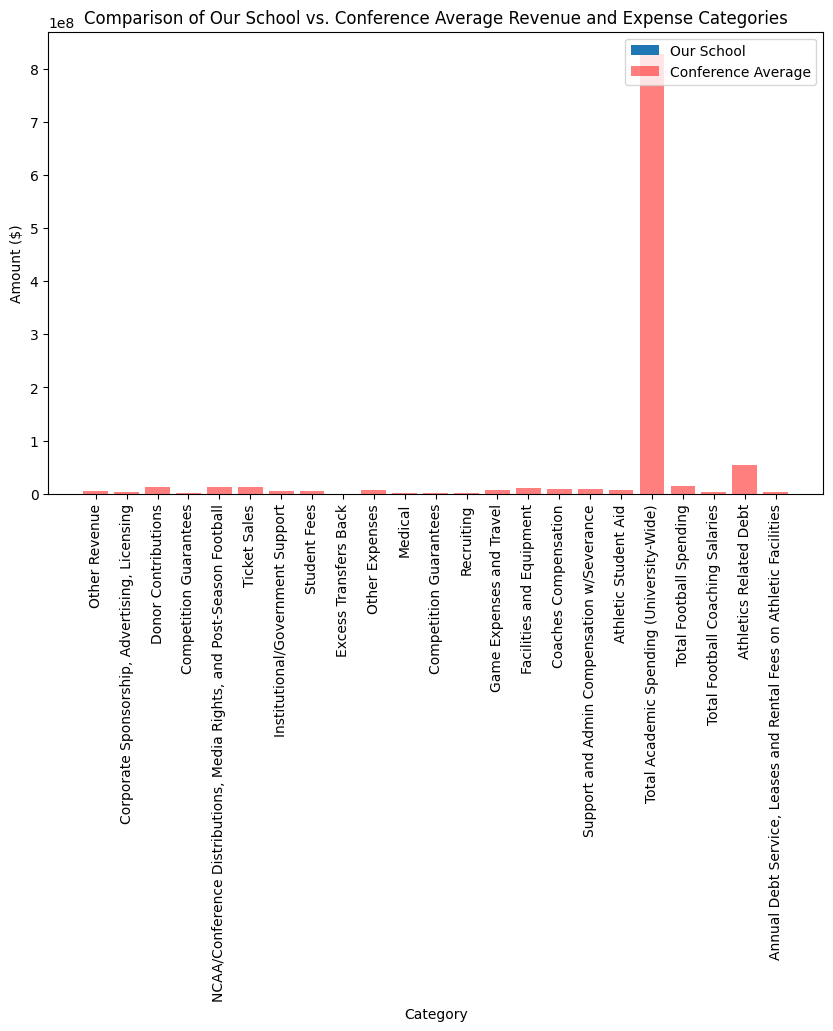

In [125]:
# define revenue and expense categories
revenue_categories = ['Other Revenue', 'Corporate Sponsorship, Advertising, Licensing',
                      'Donor Contributions', 'Competition Guarantees',
                      'NCAA/Conference Distributions, Media Rights, and Post-Season Football',
                      'Ticket Sales', 'Institutional/Government Support', 'Student Fees']
expense_categories = ['Excess Transfers Back', 'Other Expenses', 'Medical', 'Competition Guarantees', 
                      'Recruiting', 'Game Expenses and Travel', 'Facilities and Equipment', 'Coaches Compensation', 
                      'Support and Admin Compensation w/Severance', 'Athletic Student Aid', 'Total Academic Spending (University-Wide)', 
                      'Total Football Spending', 'Total Football Coaching Salaries', 'Athletics Related Debt', 
                      'Annual Debt Service, Leases and Rental Fees on Athletic Facilities']

# calculate total revenues, expenses, and profits
revenue_df['Total Revenues'] = revenue_df[revenue_categories].sum(axis=1)
revenue_df['Total Expenses'] = revenue_df[expense_categories].sum(axis=1)
revenue_df['Profit'] = revenue_df['Total Revenues'] - revenue_df['Total Expenses']

# create a new dataframe for conference data
conference_data = pd.DataFrame()

# calculate the average revenue and expense categories for the conference
for category in revenue_categories + expense_categories:
    conference_data[category] = [revenue_df[category].mean()]

# set the index of the dataframe to 'Conference'
conference_data.index = ['FBS Conference']

# reset the index of revenue_df
revenue_df = revenue_df.reset_index()

# append the conference data to our existing data
df = pd.concat([revenue_df, conference_data], axis=0)

# plot our data compared to the conference average
fig, ax = plt.subplots(figsize=(10,6))

for i, category in enumerate(revenue_categories + expense_categories):
    ax.bar(i, df.loc[df['School']=='Our School', category], color='b', alpha=0.5)
    ax.bar(i, df.loc['FBS Conference', category], color='r', alpha=0.5)
    
ax.set_xticks(range(len(revenue_categories + expense_categories)))
ax.set_xticklabels(revenue_categories + expense_categories, rotation=90)
ax.set_xlabel('Category')
ax.set_ylabel('Amount ($)')
ax.set_title('Comparison of Our School vs. Conference Average Revenue and Expense Categories')

plt.legend(['Our School', 'Conference Average'], loc='upper right')

plt.show()

3.4.2. To learn which states are bringing in the most money for the sports department, a US map heatmap of profits by state was made. This data might be helpful in locating possible growth areas or in focusing on new markets to attract athletes, supporters, and contributors. Additionally, it can aid the athletic department in making wise selections about expenditures for facilities, coaching personnel, and marketing initiatives. This kind of study can also be used to assess the performance of various states and pinpoint potential growth or development areas. Overall, this research can help inform strategic decision-making and offer useful insights into the athletic department's financial health.

In [139]:
# group the data by state and sum the profits
state_profit_df = revenue_df.groupby('State')['Profit'].sum().reset_index()

# create a US map heatmap
fig = px.choropleth(state_profit_df, 
                    locations='State', 
                    locationmode='USA-states',
                    color='Profit', 
                    scope='usa',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    labels={'Profit':'Profit ($)'})
fig.show()


# **3.5. Clustering Model:**

Utilise KMeans revenue clustering to classify NCAA institutions according to their sources of income. This can offer insightful information about the various revenue models that institutions use and how they stack up against others in their cluster. We are able to display the clustering findings on a scatter plot by creating revenue categories, one-hot encoding the data, standardising it, and lowering dimensionality using PCA. By doing so, it may be possible to spot patterns and connections that are hidden in the raw data. In conclusion, revenue clustering can be a beneficial tool for comprehending the financial performance of NCAA universities and guiding strategic choice-making.

In [81]:
# select the columns for clustering
cluster_data = ['Other Revenue', 'Corporate Sponsorship, Advertising, Licensing', 
              'Donor Contributions', 'Competition Guarantees', 
              'NCAA/Conference Distributions, Media Rights, and Post-Season Football', 
              'Ticket Sales', 'Institutional/Government Support', 'Student Fees']

In [ ]:
# standardize the data
scaler = StandardScaler()
cluster_data_std = scaler.fit_transform(cluster_data)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

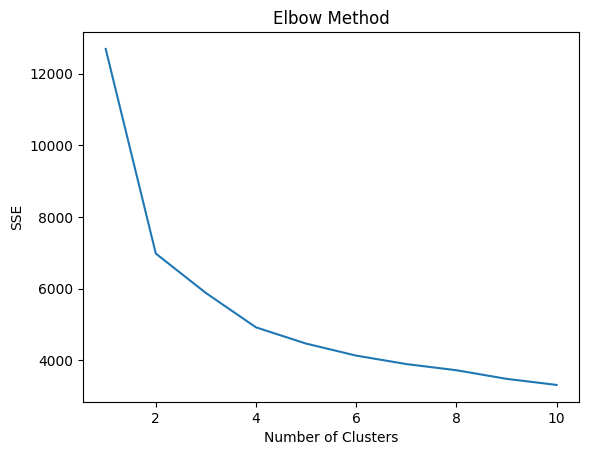

In [83]:
# use the elbow method to determine the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_std)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


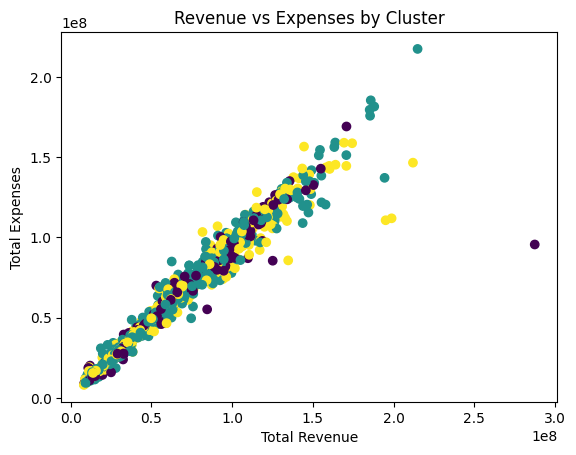

In [73]:
# fit KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(cluster_data_std)

# add the cluster labels to the original data
revenue_df['Cluster'] = kmeans.labels_

# visualize the clusters
plt.scatter(revenue_df['Total Revenues'], revenue_df['Total Expenses'], c=revenue_df['Cluster'])
plt.xlabel('Total Revenue')
plt.ylabel('Total Expenses')
plt.title('Revenue vs Expenses by Cluster')
plt.show()


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


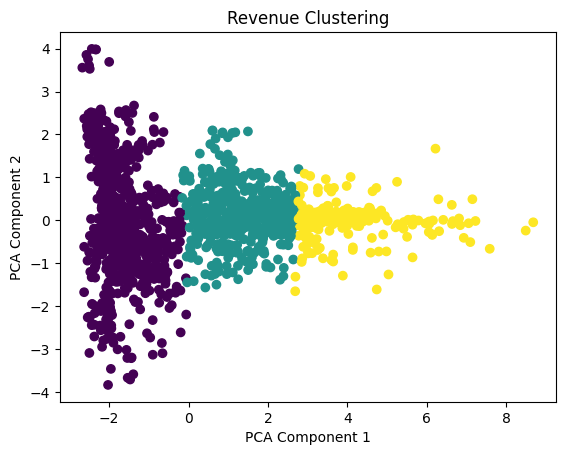

In [44]:
# define revenue categories
categories = ['Other Revenue', 'Corporate Sponsorship, Advertising, Licensing', 
              'Donor Contributions', 'Competition Guarantees', 
              'NCAA/Conference Distributions, Media Rights, and Post-Season Football', 
              'Ticket Sales', 'Institutional/Government Support', 'Student Fees']

# filter the data to include only the revenue categories
cluster_data = revenue_df[categories]

# one-hot encode the categorical variable
cluster_data_encoded = pd.get_dummies(cluster_data)

# standardize the data
scaler = StandardScaler()
cluster_data_std = scaler.fit_transform(cluster_data_encoded)

# apply PCA to reduce dimensionality
pca = PCA(n_components=2)
cluster_data_pca = pca.fit_transform(cluster_data_std)

# perform clustering using KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_data_pca)

# visualize the clustering results
plt.scatter(cluster_data_pca[:,0], cluster_data_pca[:,1], c=kmeans.labels_)
plt.title('Revenue Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


# **3.6. Time-Series Model:**

Apply a number of time series analytic techniques to the NCAA Profit and Losses dataset to demonstrate their use. Understanding the trends in total revenue over time and making revenue projections are the objectives of this analysis.

A time series plot of total income over time is shown in the first graph, which gives a general idea of the trend and seasonality of the data. By breaking down the time series into its trend, seasonal, and residual components, the second graphic makes it easier to spot patterns and oscillations in the data.

The third plot displays the time series' autocorrelation and partial autocorrelation functions, which are helpful in choosing the right time series model parameters.

The fourth portion predicts future revenue by fitting a seasonal ARIMA (SARIMA) model to the time series. A group of time series models known as SARIMA models also include seasonality and both moving average (MA) and autoregressive (AR) components. The values that are anticipated can be utilised to guide planning and decision-making for upcoming business operations.

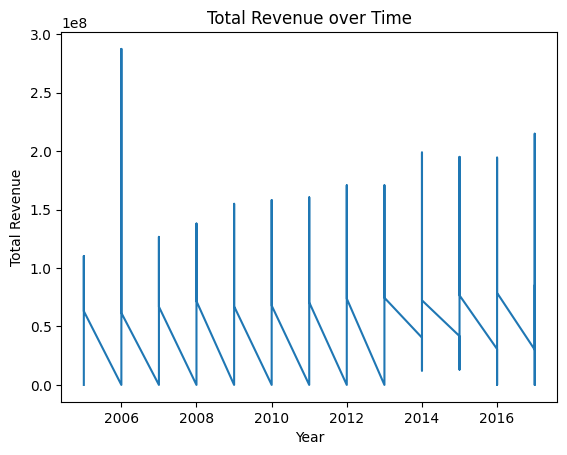

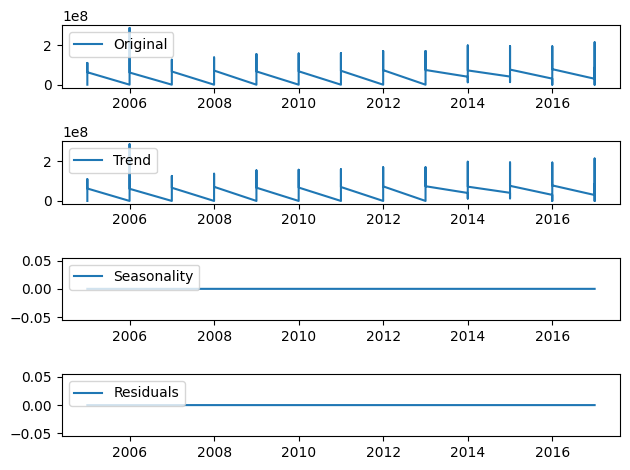

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


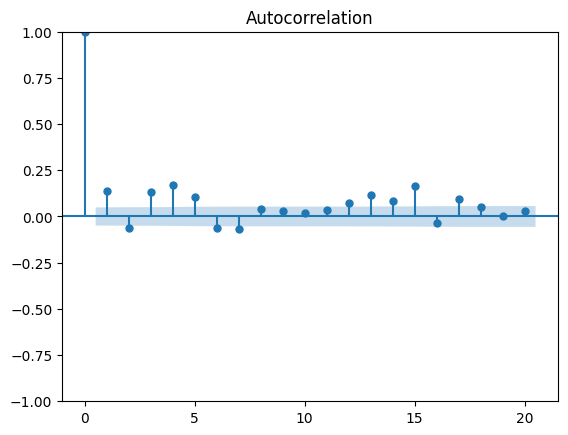

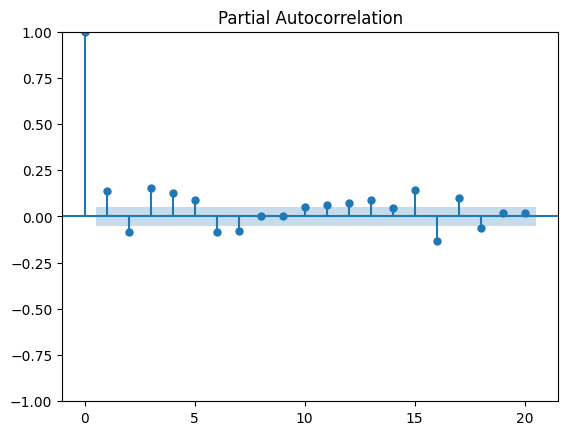

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


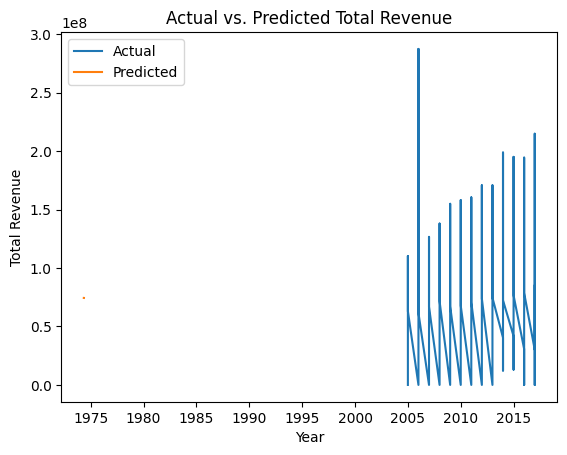

In [54]:
# load the dataset
df = pd.read_excel('NCAA Profit and Losses.xlsx', index_col='Year', parse_dates=True)

# create a time series plot
plt.plot(df.index, df['Total Revenues'])
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.title('Total Revenue over Time')
plt.show()

# decompose the time series
decomposition = seasonal_decompose(df['Total Revenues'], model='additive', period=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot the decomposed time series
plt.subplot(411)
plt.plot(df['Total Revenues'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# plot the autocorrelation and partial autocorrelation functions
plot_acf(df['Total Revenues'], lags=20)
plot_pacf(df['Total Revenues'], lags=20)
plt.show()

# fit a SARIMA model
model = SARIMAX(df['Total Revenues'], order=(1,0,1), seasonal_order=(0,0,0,4))
results = model.fit()

# generate predictions
predictions = results.predict(start=len(df), end=len(df)+4, dynamic=True)

# plot the actual vs. predicted values
plt.plot(df.index, df['Total Revenues'], label='Actual')
plt.plot(predictions.index, predictions, label='Predicted')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.title('Actual vs. Predicted Total Revenue')
plt.show()
